In [1]:
import sys
import os
import warnings
import json
from pathlib import Path

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from dotenv import load_dotenv
import google.generativeai as genai

if str(Path().resolve().parent) not in sys.path:
    sys.path.append(str(Path().resolve().parent))

load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

warnings.filterwarnings("ignore", category=FutureWarning)

from src.config import (PREPROCESSED_BLOG_DATASET_PATH, CLASSIFICATION_MAP, NUMERIC_RESULTS_PATH,
                        NORMALIZED_NUMERIC_RESULTS_PATH, CLASSIFICATION_ACC_RESULTS_PATH,
                        CLASSIFICATION_MAE_RESULTS_PATH,
                        CLASSIFICATION_RMSE_RESULTS_PATH, PREPROCESSED_DEEPMIND_BLOG_DATASET_PATH,
                        DEEPMIND_BLOG_EVALUATION_RESULTS_PATH, EXAMPLES_PATH)
from src.models_setup import gemini_2_flash, gemini_2_flash_lite, gemini_1_5_flash
from src.prompts import *
from src.output_formats import *
from src.helpers import extract_llm_assessment

# Data Processing

In [2]:
# Import data
blogs = pd.read_csv(PREPROCESSED_BLOG_DATASET_PATH).reset_index(drop=True)
google_blogs = pd.read_csv(PREPROCESSED_DEEPMIND_BLOG_DATASET_PATH).reset_index(drop=True)

with open(f"{EXAMPLES_PATH}/worst_blog.json", "r", encoding="utf-8") as f:
    worst_blog = json.load(f)
with open(f"{EXAMPLES_PATH}/best_blog.json", "r", encoding="utf-8") as f:
    best_blog = json.load(f)

excellent_blog = None
with open(f"{EXAMPLES_PATH}/excellent_blog", "r", encoding="utf-8") as f:
    f.read(excellent_blog)
very_good_blog = None
with open(f"{EXAMPLES_PATH}/very_good_blog", "r", encoding="utf-8") as f:
    f.read(very_good_blog)
good_blog = None
with open(f"{EXAMPLES_PATH}/good_blog", "r", encoding="utf-8") as f:
    f.read(good_blog)
average_blog = None
with open(f"{EXAMPLES_PATH}/average_blog", "r", encoding="utf-8") as f:
    f.read(average_blog)
bad_blog = None
with open(f"{EXAMPLES_PATH}/bad_blog", "r", encoding="utf-8") as f:
    f.read(bad_blog)

In [3]:
# Split dataset into validation and test set
Xval, Xtest, yval_score, ytest_score = train_test_split(
    blogs.drop(columns=['normalized_engagement_score']), blogs["normalized_engagement_score"],
    test_size=0.4, shuffle=False)

# Same Xval, Xtest; new explained variable "engagement_level"
Xval, Xtest, yval_level, ytest_level = train_test_split(
    blogs.drop(columns=['engagement_level', 'engagement_score', "normalized_engagement_score"]), blogs["engagement_level"],
    test_size=0.4, shuffle=False)

print(f"Size of validation set, X: {Xval.shape}, y: {yval_score.shape}")
print(f"Size of test set, X: {Xtest.shape}, y: {ytest_score.shape}")

Size of validation set, X: (27, 11), y: (27,)
Size of test set, X: (18, 11), y: (18,)


In [4]:
blog_text = Xval.loc[6, "blog_full_text"]
print(blog_text)

# Model-Free Risk-Sensitive Reinforcement Learning

By the Safety Analysis Team: Grégoire Delétang, Jordi Grau-Moya, Markus Kunesch, Tim Genewein, Rob Brekelmans, Shane Legg, and Pedro A. Ortega

Read our paper here: https://arxiv.org/abs/2111.02907

W
e’re all familiar with risk-sensitive choices. As you look out of the window, you see a few gray clouds and no rain, but decide to take along the umbrella anyway. You’re convinced your application will be successful, but you apply for other positions nevertheless. You hurry to get to an important appointment on time, but avoid the highway just in case there could be a traffic jam. Or you buy a lottery ticket all the while you know the chances of winning are unreasonably slim. All these are instances of risk-sensitive behavior — mostly risk-averse but occasionally risk-seeking too. This means we tend to value uncertain events less/more than their expected value, preempting outcomes that go against our expectations.

# Why risk-sensitivity

# Prompt Engineering

In [14]:
def test_prompt(prompt_template, model, input_variables):
    """Testing the operation of LLM with a given prompt template."""
    test_chain = prompt_template | model
    test_response = test_chain.invoke(input_variables)
    print(f"Usage metadata:\n{test_response.usage_metadata}")
    print(f"\nContent:\n{test_response.content}")

In [15]:
# One word answer
test_prompt(prompt_simple_answer, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 2115, 'output_tokens': 3, 'total_tokens': 2118, 'input_token_details': {'cache_read': 0}}

Content:
Informative


In [16]:
# Adding numerical assessment
test_prompt(prompt_numeric_rating, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 2120, 'output_tokens': 8, 'total_tokens': 2128, 'input_token_details': {'cache_read': 0}}

Content:
Informative 8/10


In [17]:
# Scale from 1 to 100 + short comment
test_prompt(prompt_short_comment, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 2131, 'output_tokens': 123, 'total_tokens': 2254, 'input_token_details': {'cache_read': 0}}

Content:
**Rating: 88/100**

**Comment:** This is a well-written and informative blog post about risk-sensitive reinforcement learning. It clearly explains the concept, its importance, and the authors' contribution to the field. The use of examples and visualizations helps to make the topic more accessible. The connection to dopamine signals and free energy adds an interesting layer. However, some parts, especially the mathematical formulas, might be challenging for readers without a strong technical background in RL. The post could also benefit from a more detailed discussion of the limitations of the proposed approach and future research directions.


In [18]:
# Emphasizing the importance of engagement
test_prompt(prompt_engagement_score, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 2137, 'output_tokens': 112, 'total_tokens': 2249, 'input_token_details': {'cache_read': 0}}

Content:
**Engagement Level: 45/100**

**Comment:** This blog post presents interesting research on a relevant topic (risk-sensitive reinforcement learning) in a clear and accessible way. However, without any visible metrics (likes, shares, comments), it's difficult to gauge actual engagement. The technical nature of the topic likely limits its appeal to a broader audience, which would impact its overall engagement score. A score of 45 reflects the potential for engagement given the content, but acknowledges the likely limited reach and unconfirmed interaction.


In [19]:
# Assessment based on several criteria
test_prompt(prompt_criteria, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 2161, 'output_tokens': 342, 'total_tokens': 2503, 'input_token_details': {'cache_read': 0}}

Content:
**Engagement Level Assessment:**

**Score:** 65/100

**Factors:**

*   **Readability:** Medium. The writing style is generally clear, but the technical jargon and equations can be a barrier for readers without a background in reinforcement learning. Use of bold font increases readability.
*   **Structure:** Good. The blog is well-organized with clear sections, headings, and a logical flow. The use of bullet points and examples aids understanding.
*   **Attractiveness of the Blog Title:** Moderate. "Model-Free Risk-Sensitive Reinforcement Learning" is descriptive but may not immediately grab the attention of a general audience. It appeals more to those already familiar with the field.
*   **Clarity:** Mostly Clear. The core concepts are explained reasonably well, but some sections (especially those with equations) require careful reading and prior knowle

In [20]:
# Separate assessment
test_prompt(prompt_separate_assessment, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 2188, 'output_tokens': 734, 'total_tokens': 2922, 'input_token_details': {'cache_read': 0}}

Content:
Okay, here's an analysis of the blog post based on the criteria you provided, with scores from 1 to 100 for each.

**Criterion Breakdown:**

*   **Readability (65/100):** The writing is generally clear, but technical jargon related to reinforcement learning ("temporal-difference learning," "quantile of the target distribution," etc.) makes it less accessible to a broader audience. The use of examples helps, but some concepts require prior knowledge. Not everyone can easily grasp the model without any previous knowledge of the subject.

*   **Structure (75/100):** The blog post follows a logical structure. It starts with an introduction, explains the problem, introduces a solution, provides an example, and discusses related concepts. The use of headings and subheadings helps break up the text, but could be improved by more visual cues (e.g., bullet point

In [21]:
# Add information about profile of the model
test_prompt(prompt_with_profile, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 2216, 'output_tokens': 673, 'total_tokens': 2889, 'input_token_details': {'cache_read': 0}}

Content:
Okay, here's my analysis of the blog post, broken down by the criteria you specified, followed by an overall assessment.

**Criterion Breakdown:**

*   **Readability (75/100):** The writing is generally accessible, and the introduction effectively uses relatable examples to explain risk-sensitivity. However, the core explanation of the update rule, with its mathematical notation, will likely be a barrier for readers without a background in reinforcement learning or mathematics. More intuitive explanations of the formula would improve readability.
*   **Structure (85/100):** The blog follows a logical structure: introduction to the concept, motivation, explanation of the approach, illustrative examples, and connections to other fields. The use of headings and subheadings is good, making it easy to scan and understand the organization.
*   **Informativene

In [22]:
# Well-structured sections of the prompt
test_prompt(prompt_structured_sections, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 2319, 'output_tokens': 820, 'total_tokens': 3139, 'input_token_details': {'cache_read': 0}}

Content:
Okay, here's my evaluation of the provided blog post based on the specified criteria:

**Individual Criterion Scores:**

*   **Readability (75/100):** The writing is generally clear and accessible, especially in the introductory sections. However, the section explaining the update rule involves mathematical notation that might be challenging for readers without a technical background.
*   **Structure (85/100):** The blog follows a logical structure: introduction to the problem, motivation, explanation of the proposed solution, and discussion of related concepts. The use of headings and subheadings improves the flow.
*   **Informativeness (80/100):** The blog provides a good overview of risk-sensitive reinforcement learning and the authors' contribution. It clearly explains the motivation behind risk-sensitivity and how it differs from risk-neutral appro

In [23]:
# 2-shot prompt
test_prompt(prompt_two_shots, gemini_2_flash, {
    "blog_text" : blog_text,
    "blog_ex1" : best_blog["blog"],
    "score_ex1" : best_blog["score"],
    "blog_ex2" : worst_blog["blog"],
    "score_ex2" : worst_blog["score"]
})

Usage metadata:
{'input_tokens': 4571, 'output_tokens': 263, 'total_tokens': 4834, 'input_token_details': {'cache_read': 0}}

Content:
```json
{
  "overall_assessment": 75.0,
  "explanation": "The blog post provides a good introduction to risk-sensitive reinforcement learning, explaining its importance and how it differs from traditional risk-neutral approaches. The use of real-world examples at the beginning helps to immediately engage the reader. The explanation of the model-free update rule is clear, though some readers may find the equations intimidating. The grid-world example effectively illustrates the impact of different risk-sensitivity parameters on the agent's behavior. The connection to dopamine signals and free energy adds depth and demonstrates the broader relevance of the work. However, the blog could be improved by adding some intuitive explanations about the equations/algorithms. The writing style is a bit academic, potentially limiting its appeal to a general audience

In [24]:
# 5-shot prompt with verbal classification
test_prompt(prompt_five_shots, gemini_2_flash, {
    "blog_text": blog_text,
    "excellent_blog": excellent_blog,
    "very_good_blog": very_good_blog,
    "good_blog": good_blog,
    "average_blog": average_blog,
    "bad_blog": bad_blog
})

Usage metadata:
{'input_tokens': 2530, 'output_tokens': 285, 'total_tokens': 2815, 'input_token_details': {'cache_read': 0}}

Content:
```json
{
  "overall_engagement_level": "Very Good",
  "explanation": "The blog post presents a complex topic (risk-sensitive reinforcement learning) in a relatively accessible way. The introduction uses relatable examples to illustrate risk-sensitivity. The structure is logical, moving from motivation to explanation to results. The language is generally clear, although some technical terms are unavoidable. However, the title is not very appealing to a broad audience and can be improved. The potential for discussion is moderate, mainly among those already familiar with reinforcement learning.",
  "possible_improvements": [
    "Revise the title to be more engaging and accessible to a broader audience. For example, something like \"Making AI More Cautious: Risk-Sensitive Reinforcement Learning\" or \"How to Train AI to Avoid Disaster: Introducing Risk-Se

In [25]:
# Zero-shot Chain-of-Thoughts
test_prompt(prompt_zero_cot, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 2403, 'output_tokens': 670, 'total_tokens': 3073, 'input_token_details': {'cache_read': 0}}

Content:
```json
{
  "readability": "The blog post has moderate readability. The initial paragraphs are accessible, using relatable examples. However, the later sections introduce more technical concepts and mathematical notations (TD learning, sigmoid functions), increasing the difficulty for a general audience. The use of jargon like 'higher-order moments' without immediate clarification also hinders readability.",
  "structure": "The structure is generally logical. It starts with an introduction to risk-sensitivity, explains its importance, discusses how agents learn it, and then introduces the authors' contribution. The use of headings and subheadings helps to break down the content. However, the transition between explaining general risk-sensitivity and diving into the specifics of the proposed model could be smoother.",
  "informativeness": "The blog provi

In [26]:
# Generated knowledge
test_prompt(prompt_generated_knowledge, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 2386, 'output_tokens': 661, 'total_tokens': 3047, 'input_token_details': {'cache_read': 0}}

Content:
```json
{
  "key_analysis": {
    "readability": "Assessing readability involves evaluating sentence structure, word choice, and the use of jargon. A blog targeting a broad audience should avoid overly technical language and complex sentence constructions.",
    "structure": "A well-structured blog post includes clear headings, subheadings, and paragraphs. Logical flow and organization of information are crucial for maintaining reader engagement.",
    "informativeness": "The blog should provide valuable insights and information to the reader. The depth and accuracy of the content are critical factors.",
    "attractiveness_of_blog_title": "The title should be engaging and accurately reflect the content of the blog. It should entice the reader to click and read further.",
    "clarity": "Clarity refers to how easily the reader can understand the present

In [27]:
# Meta prompt
test_prompt(prompt_meta, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 2587, 'output_tokens': 677, 'total_tokens': 3264, 'input_token_details': {'cache_read': 0}}

Content:
```json
{
    "Referenced blog to evaluate": "Model-Free Risk-Sensitive Reinforcement Learning",
    "Step 1": "Analyze the readability of the blog. Is the text easy to understand? Are the sentences clear and well-structured? The blog uses relatively complex terminology and mathematical notation, which may make it difficult for a general audience to understand. The sentences are generally well-structured, but the density of technical information impacts readability.",
    "Step 2": "Evaluate the structure of the blog. Does it follow a logical flow? Are the sections well-organized? The blog follows a logical structure, starting with an introduction to risk-sensitivity, explaining its importance, describing how agents learn risk-sensitive policies, and then presenting the authors' model-free approach. The sections are well-organized with clear headings.",

# Performance testing on a validation set

In [5]:
# Number of experiment repetitions
REPETITION = 5

ERROR_VALUE = -1

In [6]:
def show_scatter_plot(real_values, predicted_values):
    plt.scatter(real_values, predicted_values, color='blue')
    plt.plot([min(real_values), max(real_values)], [min(real_values), max(real_values)], color='red', linestyle='--')
    plt.xlabel('Real values')
    plt.ylabel('Predicted values')
    plt.title('Real vs Predicted values')
    plt.show()

def print_and_save_numeric_results(result_path, yval, assessments, model, loc_start):
    RMSE_list = [round(metrics.root_mean_squared_error(yval, assessment), 1) for assessment in assessments]
    print(f"Root Mean Square Error on validation set after {REPETITION} same experiments: {RMSE_list}")

    MAE_list = [round(metrics.mean_absolute_error(yval, assessment), 1) for assessment in assessments]
    print(f"Mean Absolute Error on validation set after {REPETITION} same experiments: {MAE_list}")

    try:
        results = pd.read_csv(result_path)
    except Exception as e:
        print(f"{e}\n"
              f"Creating new .csv file...")
        col = ["Model", "Experiment_ID", "RMSE", "MAE"]
        results = pd.DataFrame(columns=col)

    for index in range(REPETITION):
        results.loc[loc_start] = [model, index, RMSE_list[index], MAE_list[index]]
        loc_start += 1

    results.to_csv(result_path, index=False)

def print_and_save_classification_results(prompt_type, yval, classifications, model, loc_start):
    def create_new_dataset(error, res_type):
        print(f"{error}\n"
              f"Creating new .csv file for {res_type}...")
        col = ["Model", "Experiment_ID", "Five-shot prompt", "Zero-shot CoT prompt", "Generated Knowledge prompt", "Meta prompt"]
        res = pd.DataFrame(columns=col)
        return res

    accuracy_list = [round(metrics.accuracy_score(yval, classification) * 100, 1) for classification in classifications]
    print(f"Accuracy score on validation set after {REPETITION} same experiments (in %): {accuracy_list}")

    RMSE_list = [round(metrics.root_mean_squared_error(yval.map(CLASSIFICATION_MAP), pd.Series(classification).map(CLASSIFICATION_MAP)), 1) for classification in classifications]
    MAE_list = [round(metrics.mean_absolute_error(yval.map(CLASSIFICATION_MAP), pd.Series(classification).map(CLASSIFICATION_MAP)), 1) for classification in classifications]
    print(f"Root Mean Square Error on validation set after using the verbal classification after {REPETITION} same experiments: {RMSE_list}")
    print(f"Mean Absolute Error on validation set after using verbal after {REPETITION} same experiments: {MAE_list}")

    try:
        results_ACC = pd.read_csv(CLASSIFICATION_ACC_RESULTS_PATH)
    except Exception as e:
        results_ACC = create_new_dataset(e, "Classification Accuracy")

    try:
        results_RMSE = pd.read_csv(CLASSIFICATION_RMSE_RESULTS_PATH)
    except Exception as e:
        results_RMSE = create_new_dataset(e, "Classification RMSE")

    try:
        results_MAE = pd.read_csv(CLASSIFICATION_MAE_RESULTS_PATH)
    except Exception as e:
        results_MAE = create_new_dataset(e, "Classification MAE")

    for index in range(REPETITION):
        results_ACC.loc[loc_start, "Model"] = model
        results_RMSE.loc[loc_start, "Model"] = model
        results_MAE.loc[loc_start, "Model"] = model

        results_ACC.loc[loc_start, prompt_type] = accuracy_list[index]
        results_RMSE.loc[loc_start, prompt_type] = RMSE_list[index]
        results_MAE.loc[loc_start, prompt_type] = MAE_list[index]

        results_ACC.loc[loc_start, "Experiment_ID"] = index
        results_RMSE.loc[loc_start, "Experiment_ID"] = index
        results_MAE.loc[loc_start, "Experiment_ID"] = index

        loc_start += 1

    results_ACC.to_csv(CLASSIFICATION_ACC_RESULTS_PATH, index=False)
    results_RMSE.to_csv(CLASSIFICATION_RMSE_RESULTS_PATH, index=False)
    results_MAE.to_csv(CLASSIFICATION_MAE_RESULTS_PATH, index=False)

## Numeric evaluation with two-shot prompt


In [ ]:
# Models
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogEvaluation, include_raw=True)
gemini_2_flash_lite_structured = gemini_2_flash_lite.with_structured_output(BlogEvaluation, include_raw=True)
gemini_1_5_flash_structured = gemini_1_5_flash.with_structured_output(BlogEvaluation, include_raw=True)

### Gemini 2.0 Flash

In [7]:
flash_assessment_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    flash_assessment = extract_llm_assessment(Xval, prompt_two_shots, gemini_2_flash_structured,
                                              {
                                                  "blog_ex1" : best_blog["blog"],
                                                  "score_ex1" : best_blog["score"],
                                                  "blog_ex2" : worst_blog["blog"],
                                                  "score_ex2" : worst_blog["score"]
                                              })
    if ERROR_VALUE in flash_assessment:
        continue
    successful_attempts += 1
    flash_assessment_list.append(flash_assessment)

In [8]:
print_and_save_numeric_results(NUMERIC_RESULTS_PATH, yval_score, flash_assessment_list, "Gemini 2.0 Flash", 0)

Root Mean Square Error on validation set after 5 same experiments: [44.0, 41.6, 45.2, 42.8, 44.6]
Mean Absolute Error on validation set after 5 same experiments: [36.4, 35.1, 38.3, 36.4, 37.2]


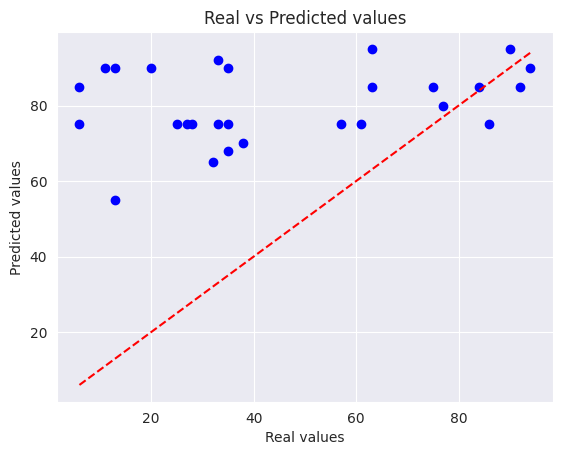

In [9]:
show_scatter_plot(yval_score, flash_assessment_list[0])

### Gemini 2.0 Flash-Lite

In [ ]:
lite_assessment_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    lite_assessment = extract_llm_assessment(Xval, prompt_two_shots, gemini_2_flash_lite_structured,
                                              {
                                                  "blog_ex1" : best_blog["blog"],
                                                  "score_ex1" : best_blog["score"],
                                                  "blog_ex2" : worst_blog["blog"],
                                                  "score_ex2" : worst_blog["score"]
                                              })
    if ERROR_VALUE in lite_assessment:
        continue
    successful_attempts += 1
    lite_assessment_list.append(lite_assessment)

In [11]:
print_and_save_numeric_results(NUMERIC_RESULTS_PATH, yval_score, lite_assessment_list, "Gemini 2.0 Flash-Lite", 5)

Root Mean Square Error on validation set after 5 same experiments: [41.5, 42.6, 40.4, 42.4, 42.9]
Mean Absolute Error on validation set after 5 same experiments: [35.0, 35.0, 33.7, 35.6, 36.7]


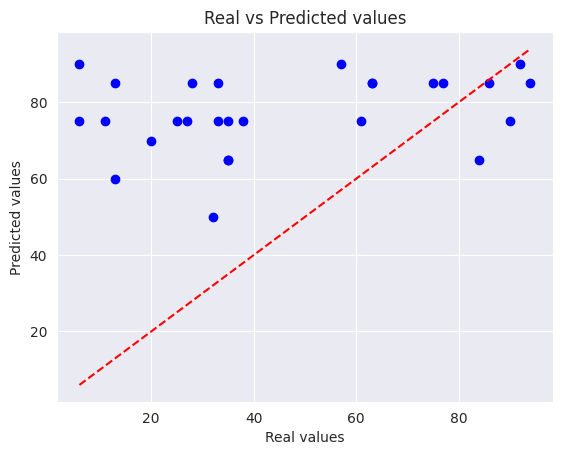

In [12]:
show_scatter_plot(yval_score, lite_assessment_list[0])

### Gemini 1.5 Flash

In [13]:
flash1_assessment_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    flash1_assessment = extract_llm_assessment(Xval, prompt_two_shots, gemini_1_5_flash_structured,
                                              {
                                                  "blog_ex1" : best_blog["blog"],
                                                  "score_ex1" : best_blog["score"],
                                                  "blog_ex2" : worst_blog["blog"],
                                                  "score_ex2" : worst_blog["score"]
                                              })
    if ERROR_VALUE in flash1_assessment:
        continue
    successful_attempts += 1
    flash1_assessment_list.append(flash1_assessment)

In [14]:
print_and_save_numeric_results(NUMERIC_RESULTS_PATH, yval_score, flash1_assessment_list, "Gemini 1.5 Flash", 10)

Root Mean Square Error on validation set after 5 same experiments: [45.9, 44.3, 43.0, 45.8, 43.1]
Mean Absolute Error on validation set after 5 same experiments: [38.7, 38.0, 36.4, 37.9, 36.9]


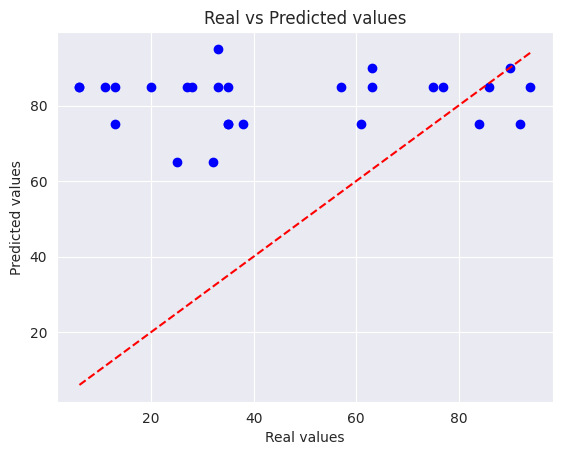

In [15]:
show_scatter_plot(yval_score, flash1_assessment_list[0])

## Normalized numeric evaluation with two-shot prompt

### Gemini 2.0 Flash

In [16]:
flash_assessment_scaler = MinMaxScaler(feature_range=(1, 100))
flash_assessment_scaler.fit(np.array(flash_assessment_list).flatten().reshape(-1, 1))
scaled_flash_assessment_list = []
for assessment in flash_assessment_list:
    scaled_assessment = flash_assessment_scaler.transform(np.array(assessment).reshape(-1, 1))
    scaled_flash_assessment_list.append(scaled_assessment)

print_and_save_numeric_results(NORMALIZED_NUMERIC_RESULTS_PATH, yval_score, scaled_flash_assessment_list, "Gemini 2.0 Flash", 0)

Root Mean Square Error on validation set after 5 same experiments: [32.0, 24.5, 34.4, 30.0, 35.0]
Mean Absolute Error on validation set after 5 same experiments: [25.1, 19.0, 27.1, 24.8, 28.2]


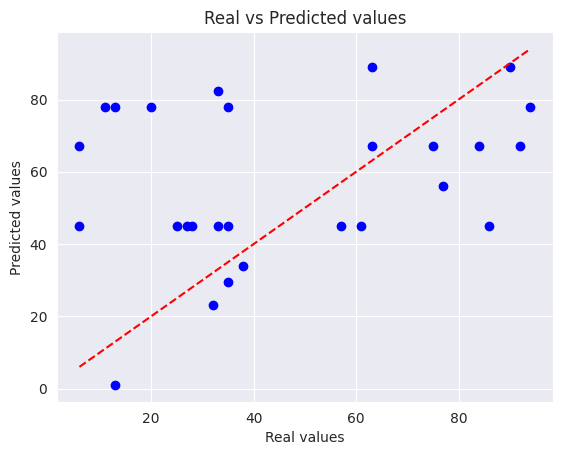

In [17]:
show_scatter_plot(yval_score, scaled_flash_assessment_list[0])

### Gemini 2.0 Flash-Lite

In [18]:
lite_assessment_scaler = MinMaxScaler(feature_range=(1, 100))
lite_assessment_scaler.fit(np.array(lite_assessment_list).flatten().reshape(-1, 1))
scaled_lite_assessment_list = []
for assessment in lite_assessment_list:
    scaled_assessment = lite_assessment_scaler.transform(np.array(assessment).reshape(-1, 1))
    scaled_lite_assessment_list.append(scaled_assessment)

print_and_save_numeric_results(NORMALIZED_NUMERIC_RESULTS_PATH, yval_score, scaled_lite_assessment_list, "Gemini 2.0 Flash-Lite", 5)

Root Mean Square Error on validation set after 5 same experiments: [38.8, 40.8, 37.9, 40.2, 41.1]
Mean Absolute Error on validation set after 5 same experiments: [31.8, 32.8, 32.2, 33.1, 34.6]


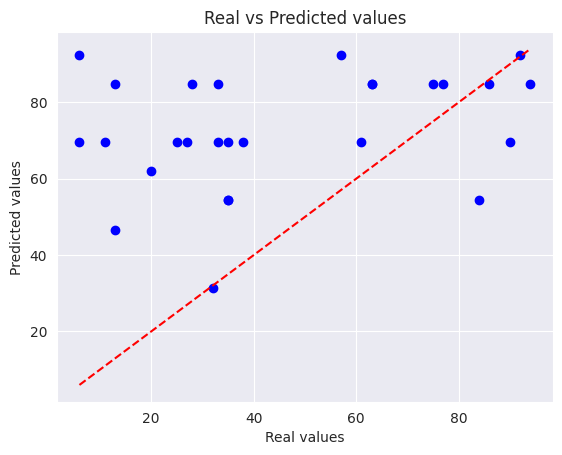

In [19]:
show_scatter_plot(yval_score, scaled_lite_assessment_list[0])

### Gemini 1.5 Flash

In [20]:
flash1_assessment_scaler = MinMaxScaler(feature_range=(1, 100))
flash1_assessment_scaler.fit(np.array(flash1_assessment_list).flatten().reshape(-1, 1))
scaled_flash1_assessment_list = []
for assessment in flash1_assessment_list:
    scaled_assessment = flash1_assessment_scaler.transform(np.array(assessment).reshape(-1, 1))
    scaled_flash1_assessment_list.append(scaled_assessment)

print_and_save_numeric_results(NORMALIZED_NUMERIC_RESULTS_PATH, yval_score, scaled_flash1_assessment_list, "Gemini 1.5 Flash", 10)

Root Mean Square Error on validation set after 5 same experiments: [44.9, 42.5, 41.6, 45.0, 40.7]
Mean Absolute Error on validation set after 5 same experiments: [37.6, 36.3, 34.7, 36.6, 34.9]


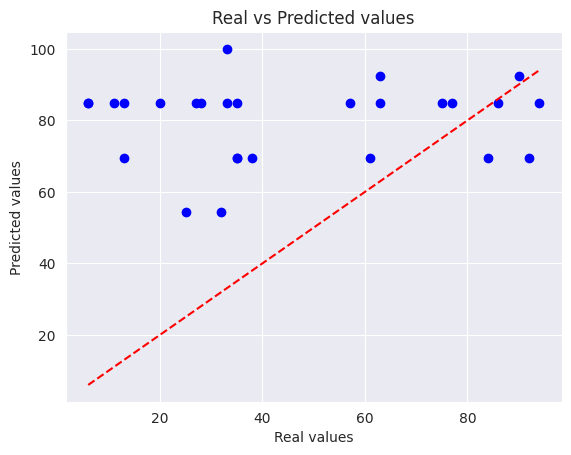

In [21]:
show_scatter_plot(yval_score, scaled_flash1_assessment_list[0])

## Classification with five-shot prompt

In [22]:
# Models
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassification, include_raw=True)
gemini_2_flash_lite_structured = gemini_2_flash_lite.with_structured_output(BlogClassification, include_raw=True)
gemini_1_5_flash_structured = gemini_1_5_flash.with_structured_output(BlogClassification, include_raw=True)

### Gemini 2.0 Flash

In [ ]:
flash_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    flash_classification = extract_llm_assessment(Xval, prompt_five_shots, gemini_2_flash_structured,
                                                  examples=
                                                  {
                                                      "excellent_blog" : excellent_blog,
                                                      "very_good_blog" : very_good_blog,
                                                      "good_blog" : good_blog,
                                                      "average_blog" : average_blog,
                                                      "bad_blog" : bad_blog
                                                  })
    if ERROR_VALUE in flash_classification:
        continue
    successful_attempts += 1
    flash_classification_list.append(flash_classification)

In [24]:
print_and_save_classification_results("Five-shot prompt", yval_level, flash_classification_list, "Gemini 2.0 Flash", 0)

Accuracy score on validation set after 5 same experiments (in %): [25.9, 37.0, 22.2, 29.6, 29.6]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.5, 1.5, 1.5, 1.5, 1.5]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [1.1, 1.1, 1.3, 1.1, 1.1]


### Gemini 2.0 Flash-Lite

In [ ]:
lite_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    lite_classification = extract_llm_assessment(Xval, prompt_five_shots, gemini_2_flash_lite_structured,
                                                 examples=
                                                 {
                                                     "excellent_blog" : excellent_blog,
                                                     "very_good_blog" : very_good_blog,
                                                     "good_blog" : good_blog,
                                                     "average_blog" : average_blog,
                                                     "bad_blog" : bad_blog
                                                 })
    if ERROR_VALUE in lite_classification:
        continue
    successful_attempts += 1
    lite_classification_list.append(lite_classification)

In [26]:
print_and_save_classification_results("Five-shot prompt", yval_level, lite_classification_list, "Gemini 2.0 Flash-Lite", 5)

Accuracy score on validation set after 5 same experiments (in %): [29.6, 18.5, 18.5, 18.5, 22.2]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.4, 1.5, 1.5, 1.4, 1.4]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [1.1, 1.2, 1.3, 1.2, 1.1]


### Gemini 1.5 Flash

In [27]:
flash1_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    flash1_classification = extract_llm_assessment(Xval, prompt_five_shots, gemini_1_5_flash_structured,
                                                   examples=
                                                   {
                                                       "excellent_blog" : excellent_blog,
                                                       "very_good_blog" : very_good_blog,
                                                       "good_blog" : good_blog,
                                                       "average_blog" : average_blog,
                                                       "bad_blog" : bad_blog
                                                   })
    if ERROR_VALUE in flash1_classification:
        continue
    successful_attempts += 1
    flash1_classification_list.append(flash1_classification)

In [28]:
print_and_save_classification_results("Five-shot prompt", yval_level, flash1_classification_list, "Gemini 1.5 Flash", 10)

Accuracy score on validation set after 5 same experiments (in %): [29.6, 33.3, 29.6, 33.3, 29.6]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.5, 1.4, 1.6, 1.5, 1.5]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [1.2, 1.1, 1.2, 1.1, 1.1]


## Classification with Chain-of-Thoughts prompt

In [100]:
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassificationCoT, include_raw=True)
gemini_2_flash_lite_structured = gemini_2_flash_lite.with_structured_output(BlogClassificationCoT, include_raw=True)
gemini_1_5_flash_structured = gemini_1_5_flash.with_structured_output(BlogClassificationCoT, include_raw=True)

### Gemini 2.0 Flash

In [101]:
flash_cot_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    flash_cot_classification = extract_llm_assessment(Xval, prompt_zero_cot, gemini_2_flash_structured, examples={})

    if ERROR_VALUE in flash_cot_classification:
        continue
    successful_attempts += 1
    flash_cot_classification_list.append(flash_cot_classification)

In [102]:
print_and_save_classification_results("Zero-shot CoT prompt", yval_level, flash_cot_classification_list, "Gemini 2.0 Flash", 0)

Accuracy score on validation set after 5 same experiments (in %): [33.3, 18.5, 25.9, 29.6, 29.6]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.4, 1.5, 1.3, 1.6, 1.4]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [1.1, 1.2, 1.1, 1.2, 1.1]


### Gemini 2.0 Flash-Lite

In [ ]:
lite_cot_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    lite_cot_classification = extract_llm_assessment(Xval, prompt_zero_cot, gemini_2_flash_lite_structured, examples={})

    if ERROR_VALUE in lite_cot_classification:
        continue
    successful_attempts += 1
    lite_cot_classification_list.append(lite_cot_classification)

In [104]:
print_and_save_classification_results("Zero-shot CoT prompt", yval_level, lite_cot_classification_list, "Gemini 2.0 Flash-Lite", 5)

Accuracy score on validation set after 5 same experiments (in %): [18.5, 18.5, 25.9, 7.4, 25.9]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.6, 1.6, 1.5, 1.5, 1.6]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [1.3, 1.3, 1.2, 1.3, 1.3]


### Gemini 1.5 Flash

In [ ]:
flash1_cot_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    flash1_cot_classification = extract_llm_assessment(Xval, prompt_zero_cot, gemini_1_5_flash_structured, examples={})

    if ERROR_VALUE in flash1_cot_classification:
        continue
    successful_attempts += 1
    flash1_cot_classification_list.append(flash1_cot_classification)

In [106]:
print_and_save_classification_results("Zero-shot CoT prompt", yval_level, flash1_cot_classification_list, "Gemini 1.5 Flash", 10)

Accuracy score on validation set after 5 same experiments (in %): [14.8, 25.9, 18.5, 18.5, 22.2]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [2.0, 2.0, 2.0, 2.1, 2.0]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [1.7, 1.6, 1.6, 1.7, 1.6]


## Classification with generated knowledge prompt

In [38]:
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassificationGK, include_raw=True)
gemini_2_flash_lite_structured = gemini_2_flash_lite.with_structured_output(BlogClassificationGK, include_raw=True)
gemini_1_5_flash_structured = gemini_1_5_flash.with_structured_output(BlogClassificationGK, include_raw=True)

### Gemini 2.0 Flash

In [ ]:
flash_gk_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    flash_gk_classification = extract_llm_assessment(Xval, prompt_generated_knowledge, gemini_2_flash_structured, examples={})

    if ERROR_VALUE in flash_gk_classification:
        continue
    successful_attempts += 1
    flash_gk_classification_list.append(flash_gk_classification)

In [40]:
print_and_save_classification_results("Generated Knowledge prompt", yval_level, flash_gk_classification_list, "Gemini 2.0 Flash", 0)

Accuracy score on validation set after 5 same experiments (in %): [33.3, 33.3, 29.6, 25.9, 25.9]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.5, 1.4, 1.5, 1.5, 1.4]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [1.1, 1.1, 1.1, 1.2, 1.1]


### Gemini 2.0 Flash-Lite

In [ ]:
lite_gk_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    lite_gk_classification = extract_llm_assessment(Xval, prompt_generated_knowledge, gemini_2_flash_lite_structured, examples={})

    if ERROR_VALUE in lite_gk_classification:
        continue
    successful_attempts += 1
    lite_gk_classification_list.append(lite_gk_classification)

In [42]:
print_and_save_classification_results("Generated Knowledge prompt", yval_level, lite_gk_classification_list, "Gemini 2.0 Flash-Lite", 5)

Accuracy score on validation set after 5 same experiments (in %): [25.9, 33.3, 18.5, 18.5, 25.9]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.5, 1.5, 1.4, 1.6, 1.5]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [1.1, 1.1, 1.2, 1.3, 1.2]


### Gemini 1.5 Flash

In [43]:
flash1_gk_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    flash1_gk_classification = extract_llm_assessment(Xval, prompt_generated_knowledge, gemini_1_5_flash_structured, examples={})

    if ERROR_VALUE in flash1_gk_classification:
        continue
    successful_attempts += 1
    flash1_gk_classification_list.append(flash1_gk_classification)

In [44]:
print_and_save_classification_results("Generated Knowledge prompt", yval_level, flash1_gk_classification_list, "Gemini 1.5 Flash", 10)

Accuracy score on validation set after 5 same experiments (in %): [29.6, 25.9, 29.6, 33.3, 22.2]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.4, 1.4, 1.6, 1.3, 1.4]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [1.1, 1.1, 1.2, 1.0, 1.2]


## Classification with Meta prompt

In [79]:
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassificationMP, include_raw=True)
gemini_2_flash_lite_structured = gemini_2_flash_lite.with_structured_output(BlogClassificationMP, include_raw=True)
gemini_1_5_flash_structured = gemini_1_5_flash.with_structured_output(BlogClassificationMP, include_raw=True)

### Gemini 2.0 Flash

In [ ]:
flash_mp_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    flash_mp_classification = extract_llm_assessment(Xval, prompt_meta, gemini_2_flash_structured, examples={})

    if ERROR_VALUE in flash_mp_classification:
        continue
    successful_attempts += 1
    flash_mp_classification_list.append(flash_mp_classification)

In [86]:
print_and_save_classification_results("Meta prompt", yval_level, flash_mp_classification_list, "Gemini 2.0 Flash", 0)

Accuracy score on validation set after 5 same experiments (in %): [40.7, 25.9, 40.7, 40.7, 40.7]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.3, 1.4, 1.3, 1.3, 1.3]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [1.0, 1.1, 1.0, 1.0, 0.9]


### Gemini 2.0 Flash-Lite

In [ ]:
lite_mp_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    lite_mp_classification = extract_llm_assessment(Xval, prompt_meta, gemini_2_flash_lite_structured, examples={})

    if ERROR_VALUE in lite_mp_classification:
        continue
    successful_attempts += 1
    lite_mp_classification_list.append(lite_mp_classification)

In [83]:
print_and_save_classification_results("Meta prompt", yval_level, lite_mp_classification_list, "Gemini 2.0 Flash-Lite", 5)

Accuracy score on validation set after 5 same experiments (in %): [14.8, 22.2, 22.2, 22.2, 18.5]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.5, 1.5, 1.4, 1.3, 1.3]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [1.3, 1.2, 1.1, 1.1, 1.1]


### Gemini 1.5 Flash

In [84]:
flash1_mp_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    flash1_mp_classification = extract_llm_assessment(Xval, prompt_meta, gemini_1_5_flash_structured, examples={})

    if ERROR_VALUE in flash1_mp_classification:
        continue
    successful_attempts += 1
    flash1_mp_classification_list.append(flash1_mp_classification)

In [85]:
print_and_save_classification_results("Meta prompt", yval_level, flash1_mp_classification_list, "Gemini 1.5 Flash", 10)

Accuracy score on validation set after 5 same experiments (in %): [18.5, 25.9, 25.9, 25.9, 29.6]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.7, 1.8, 1.8, 1.6, 1.6]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [1.4, 1.4, 1.4, 1.2, 1.2]


# Results

In [117]:
prompts = ["Five-shot prompt", "Zero-shot CoT prompt", "Generated Knowledge prompt", "Meta prompt"]

def show_metric_bar_plot(models, values, metric, error):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8, 6))
    plt.bar(models, values, color='orange', yerr=error, capsize=5, edgecolor='black')
    plt.title(f'{metric} comparison for different models')
    plt.ylabel(f'{metric}')
    plt.ylim(min(values) - 6, max(values) + 5)
    plt.tight_layout()
    plt.show()

def show_metric_heat_map(data, metric, reverse_color=True):
    plt.figure(figsize=(8, 6))
    sns.heatmap(data.set_index('Model'), annot=True, cmap='coolwarm_r' if reverse_color else 'coolwarm', fmt='.2f')
    plt.title(f'Heatmap of {metric}')
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.show()

def calculate_error(values_list):
    confidence = 0.95
    error_list = []
    for values in values_list:
        values = np.array(values)
        mean = np.mean(values)
        sem = stats.sem(values)
        confidence_interval = stats.t.interval(confidence, df=len(values)-1, loc=mean, scale=sem)
        error_list.append(confidence_interval[1] - mean)
    return error_list

def show_metric_bar_plot_low(model, prompt_names, values, metric, error):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8, 8))
    plt.bar(prompt_names, values, color='orange', yerr=error, capsize=5, edgecolor='black')
    plt.title(f'{model} {metric} comparison for different prompts')
    plt.ylabel(f'{metric}')
    plt.ylim(min(values) - (0.2 if metric != "Accuracy" else 10), max(values) + (0.2 if metric != "Accuracy" else 10))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Numeric evaluation with two-shot prompt

In [118]:
num_eval_results = pd.read_csv(NUMERIC_RESULTS_PATH)
average_num_eval_results = num_eval_results.groupby("Model").agg({
    'RMSE': 'mean',
    'MAE': 'mean'
}).reset_index().round(2)
print(f"Average error values")
average_num_eval_results

Average error values


,Model,RMSE,MAE
0,Gemini 1.5 Flash,44.42,37.58
1,Gemini 2.0 Flash,43.64,36.68
2,Gemini 2.0 Flash-Lite,41.96,35.20


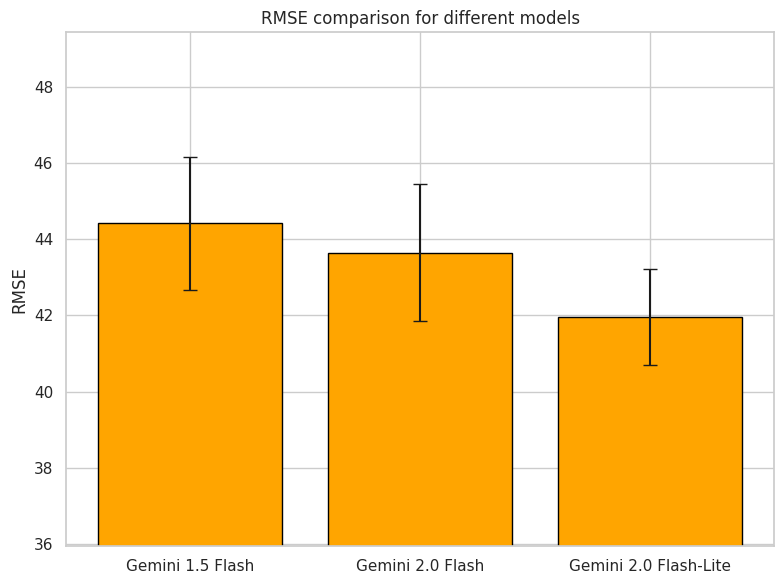

In [119]:
RMSE_error = calculate_error(num_eval_results.groupby("Model")["RMSE"].apply(list).tolist())
show_metric_bar_plot(average_num_eval_results["Model"], average_num_eval_results["RMSE"], "RMSE", RMSE_error)

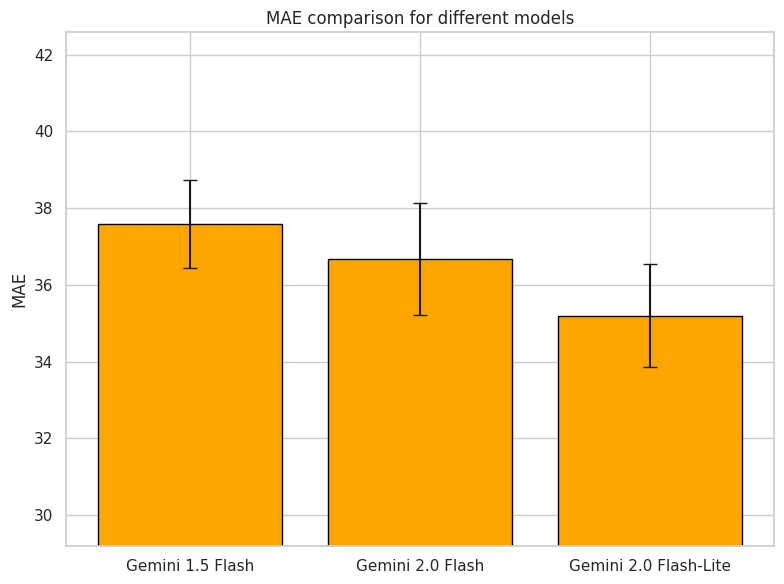

In [120]:
MAE_error = calculate_error(num_eval_results.groupby("Model")["MAE"].apply(list).tolist())
show_metric_bar_plot(average_num_eval_results["Model"], average_num_eval_results["MAE"], "MAE", MAE_error)

## Normalized numeric evaluation with two-shot prompt

In [121]:
norm_num_eval_results = pd.read_csv(NORMALIZED_NUMERIC_RESULTS_PATH)
average_norm_num_eval_results = norm_num_eval_results.groupby("Model").agg({
    'RMSE': 'mean',
    'MAE': 'mean'
}).reset_index().round(2)
print(f"Average error values")
average_norm_num_eval_results

Average error values


,Model,RMSE,MAE
0,Gemini 1.5 Flash,42.94,36.02
1,Gemini 2.0 Flash,31.18,24.84
2,Gemini 2.0 Flash-Lite,39.76,32.90


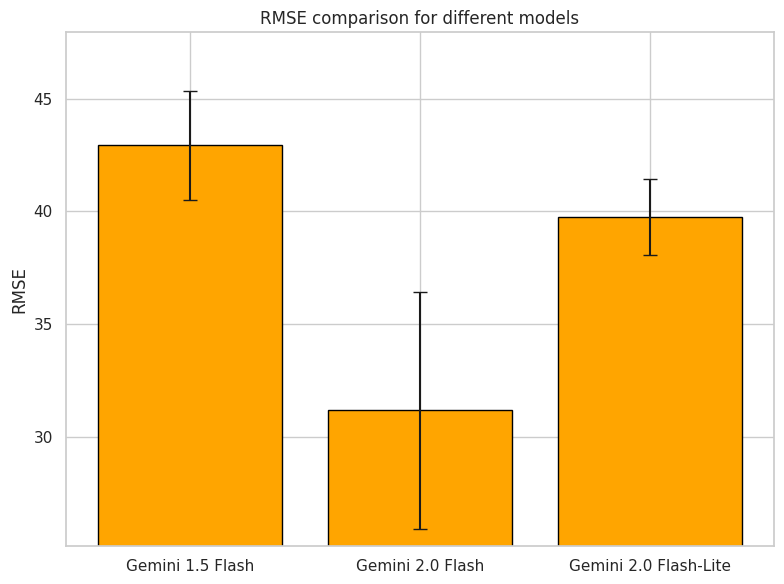

In [122]:
RMSE_error = calculate_error(norm_num_eval_results.groupby("Model")["RMSE"].apply(list).tolist())
show_metric_bar_plot(average_norm_num_eval_results["Model"], average_norm_num_eval_results["RMSE"], "RMSE", RMSE_error)

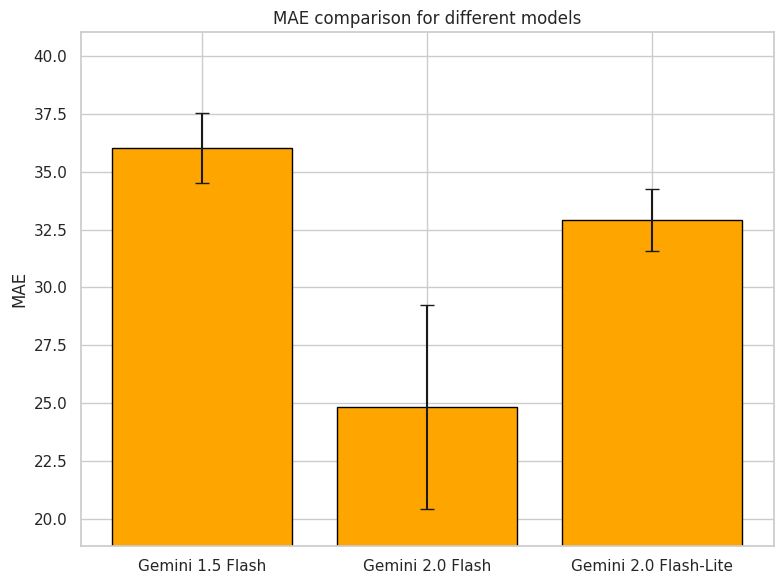

In [123]:
MAE_error = calculate_error(norm_num_eval_results.groupby("Model")["MAE"].apply(list).tolist())
show_metric_bar_plot(average_norm_num_eval_results["Model"], average_norm_num_eval_results["MAE"], "MAE", MAE_error)

## Classification RMSE

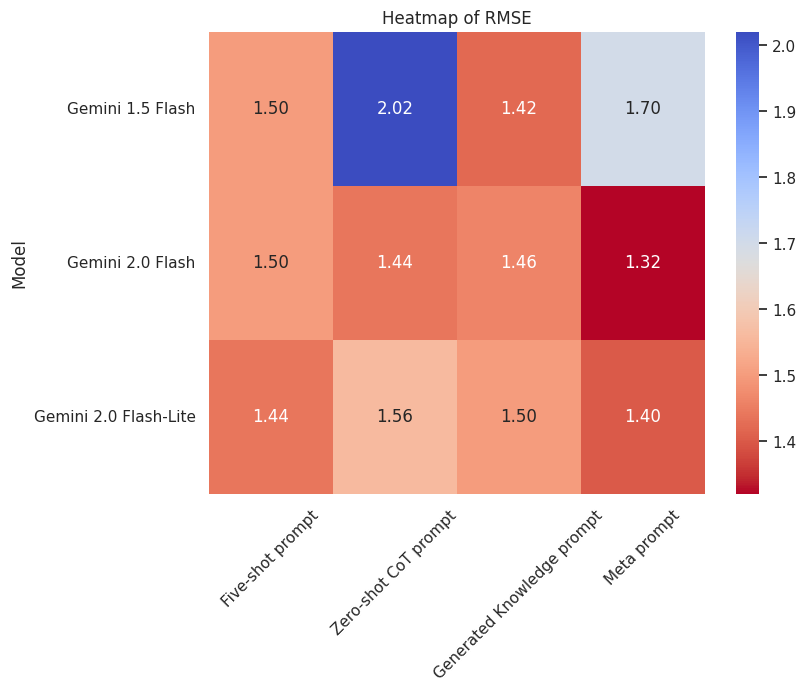

In [124]:
clas_RMSE = pd.read_csv(CLASSIFICATION_RMSE_RESULTS_PATH)
average_clas_RMSE = clas_RMSE.groupby("Model").agg({
    "Five-shot prompt": "mean",
    "Zero-shot CoT prompt": "mean",
    "Generated Knowledge prompt": "mean",
    "Meta prompt": "mean"
}).reset_index().round(2)
#print(f"Average RMSE values")
#average_clas_RMSE
show_metric_heat_map(average_clas_RMSE, "RMSE")

/home/kanstantsin-downar/virtualPython/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2304: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/kanstantsin-downar/virtualPython/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


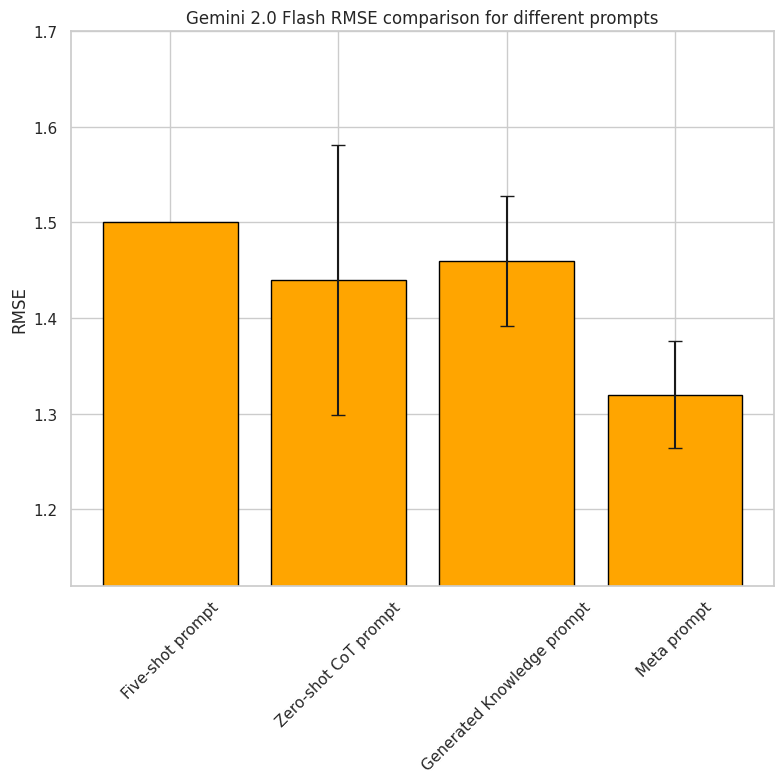

In [125]:
df = clas_RMSE[clas_RMSE["Model"] == "Gemini 2.0 Flash"]
grouped_df = df.groupby("Model").agg(list).reset_index()
RMSE_list = [grouped_df[prompt][0] for prompt in prompts]
RMSE_error = calculate_error(RMSE_list)
average_values = average_clas_RMSE[average_clas_RMSE["Model"] == "Gemini 2.0 Flash"].reset_index().loc[0][prompts].tolist()
show_metric_bar_plot_low("Gemini 2.0 Flash", prompts, average_values, "RMSE", RMSE_error)

## Classification MAE

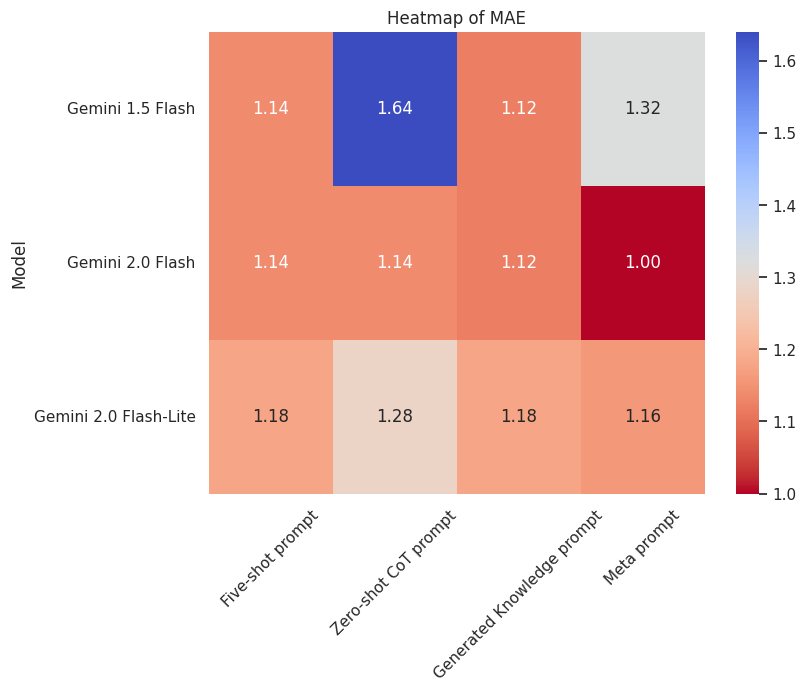

In [126]:
clas_MAE = pd.read_csv(CLASSIFICATION_MAE_RESULTS_PATH)
average_clas_MAE = clas_MAE.groupby("Model").agg({
    "Five-shot prompt": "mean",
    "Zero-shot CoT prompt": "mean",
    "Generated Knowledge prompt": "mean",
    "Meta prompt": "mean"
}).reset_index().round(2)
#print(f"Average MAE values")
#average_clas_MAE
show_metric_heat_map(average_clas_MAE, "MAE")

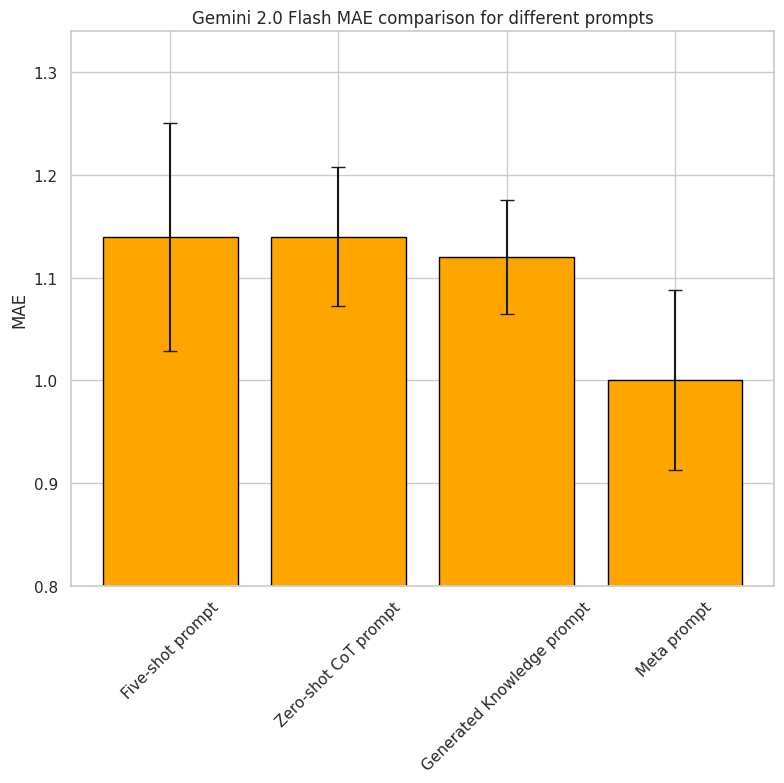

In [127]:
df = clas_MAE[clas_MAE["Model"] == "Gemini 2.0 Flash"]
grouped_df = df.groupby("Model").agg(list).reset_index()
MAE_list = [grouped_df[prompt][0] for prompt in prompts]
MAE_error = calculate_error(MAE_list)
average_values = average_clas_MAE[average_clas_MAE["Model"] == "Gemini 2.0 Flash"].reset_index().loc[0][prompts].tolist()
show_metric_bar_plot_low("Gemini 2.0 Flash", prompts, average_values, "MAE", MAE_error)

## Classification accuracy

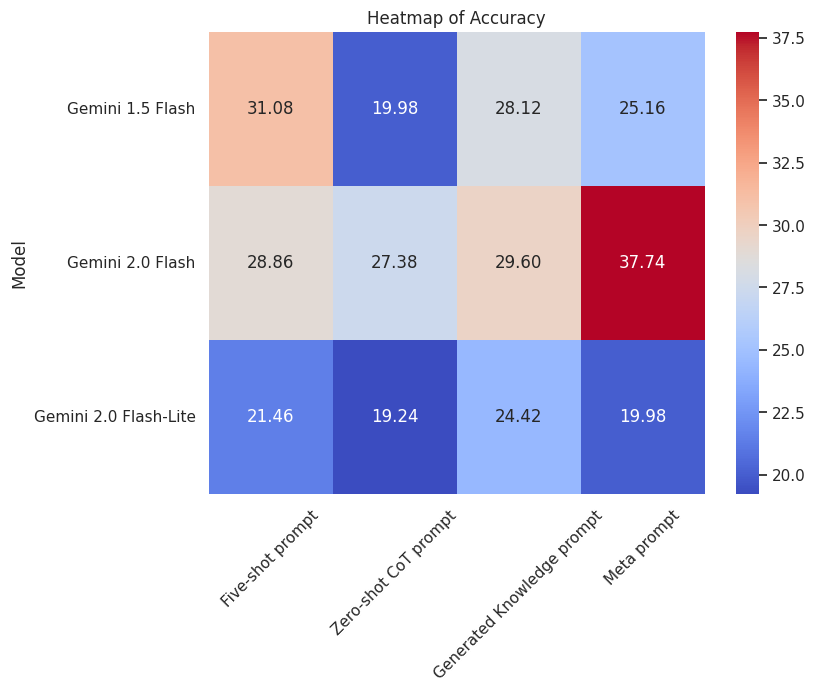

In [128]:
clas_ACC = pd.read_csv(CLASSIFICATION_ACC_RESULTS_PATH)
average_clas_ACC = clas_ACC.groupby("Model").agg({
    "Five-shot prompt": "mean",
    "Zero-shot CoT prompt": "mean",
    "Generated Knowledge prompt": "mean",
    "Meta prompt": "mean"
}).reset_index().round(2)
#print(f"Average Accuracy values")
#average_clas_ACC
show_metric_heat_map(average_clas_ACC, "Accuracy", reverse_color=False)

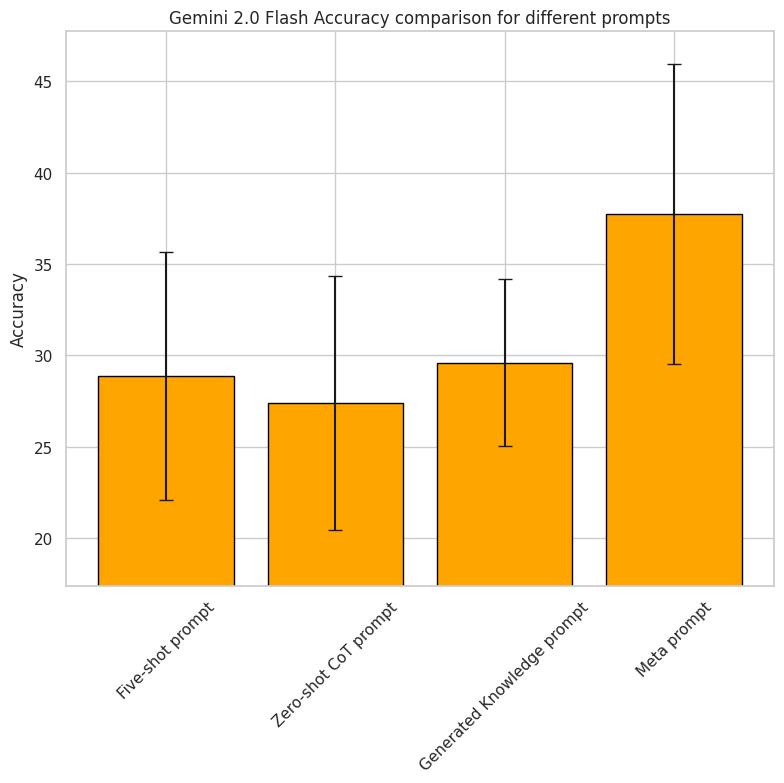

In [129]:
df = clas_ACC[clas_ACC["Model"] == "Gemini 2.0 Flash"]
grouped_df = df.groupby("Model").agg(list).reset_index()
ACC_list = [grouped_df[prompt][0] for prompt in prompts]
ACC_error = calculate_error(ACC_list)
average_values = average_clas_ACC[average_clas_ACC["Model"] == "Gemini 2.0 Flash"].reset_index().loc[0][prompts].tolist()
show_metric_bar_plot_low("Gemini 2.0 Flash", prompts, average_values, "Accuracy", ACC_error)

# Additional experiment on Google DeepMind blogs

## Meta prompt

In [130]:
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassificationMP, include_raw=True)

In [ ]:
google_mp_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    google_mp_classification = extract_llm_assessment(google_blogs, prompt_meta, gemini_2_flash_structured, examples={})

    if ERROR_VALUE in google_mp_classification:
        continue
    successful_attempts += 1
    google_mp_classification_list.append(google_mp_classification)

## Generated Knowledge prompt

In [132]:
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassificationGK, include_raw=True)

In [ ]:
google_gk_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    google_gk_classification = extract_llm_assessment(google_blogs, prompt_generated_knowledge, gemini_2_flash_structured, examples={})

    if ERROR_VALUE in google_gk_classification:
        continue
    successful_attempts += 1
    google_gk_classification_list.append(google_gk_classification)

## Zero-shot Chain-of-Thought prompt

In [140]:
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassificationCoT, include_raw=True)

In [ ]:
google_cot_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    google_cot_classification = extract_llm_assessment(google_blogs, prompt_zero_cot, gemini_2_flash_structured, examples={})

    if ERROR_VALUE in google_cot_classification:
        continue
    successful_attempts += 1
    google_cot_classification_list.append(google_cot_classification)

## Five-shot prompt

In [153]:
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassification, include_raw=True)

In [ ]:
google_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    google_classification = extract_llm_assessment(google_blogs, prompt_five_shots, gemini_2_flash_structured,
                                                   examples=
                                                  {
                                                      "excellent_blog" : excellent_blog,
                                                      "very_good_blog" : very_good_blog,
                                                      "good_blog" : good_blog,
                                                      "average_blog" : average_blog,
                                                      "bad_blog" : bad_blog
                                                  })

    if ERROR_VALUE in google_classification:
        continue
    successful_attempts += 1
    google_classification_list.append(google_classification)

## Save Results

In [ ]:
for classification in google_mp_classification_list:
    for i in range(len(classification)):
        classification[i] = CLASSIFICATION_MAP[classification[i]]

google_mp_classification_list = np.array(google_mp_classification_list)
google_mp_classification_list = np.mean(google_mp_classification_list, axis=0)

In [134]:
for classification in google_gk_classification_list:
    for i in range(len(classification)):
        classification[i] = CLASSIFICATION_MAP[classification[i]]

google_gk_classification_list = np.array(google_gk_classification_list)
google_gk_classification_list = np.mean(google_gk_classification_list, axis=0)

In [146]:
for classification in google_cot_classification_list:
    for i in range(len(classification)):
        classification[i] = CLASSIFICATION_MAP[classification[i]]

google_cot_classification_list = np.array(google_cot_classification_list)
google_cot_classification_list = np.mean(google_cot_classification_list, axis=0)

In [ ]:
for classification in google_classification_list:
    for i in range(len(classification)):
        classification[i] = CLASSIFICATION_MAP[classification[i]]

google_classification_list = np.array(google_classification_list)
google_classification_list = np.mean(google_classification_list, axis=0)

df = pd.read_csv(DEEPMIND_BLOG_EVALUATION_RESULTS_PATH)
df["Five-shot prompt"] = google_classification_list
df.to_csv(DEEPMIND_BLOG_EVALUATION_RESULTS_PATH, index=False)

In [148]:
blog_eval = {
    "Meta prompt": google_mp_classification_list,
    "Generated Knowledge prompt": google_gk_classification_list,
    "Five-shot prompt": google_classification_list,
    "Zero-shot CoT prompt": google_cot_classification_list
}
google_blog_evaluation = pd.DataFrame(blog_eval)
google_blog_evaluation.to_csv(DEEPMIND_BLOG_EVALUATION_RESULTS_PATH, index=False)

## Results

In [149]:
google_blog_evaluation = pd.read_csv(DEEPMIND_BLOG_EVALUATION_RESULTS_PATH)

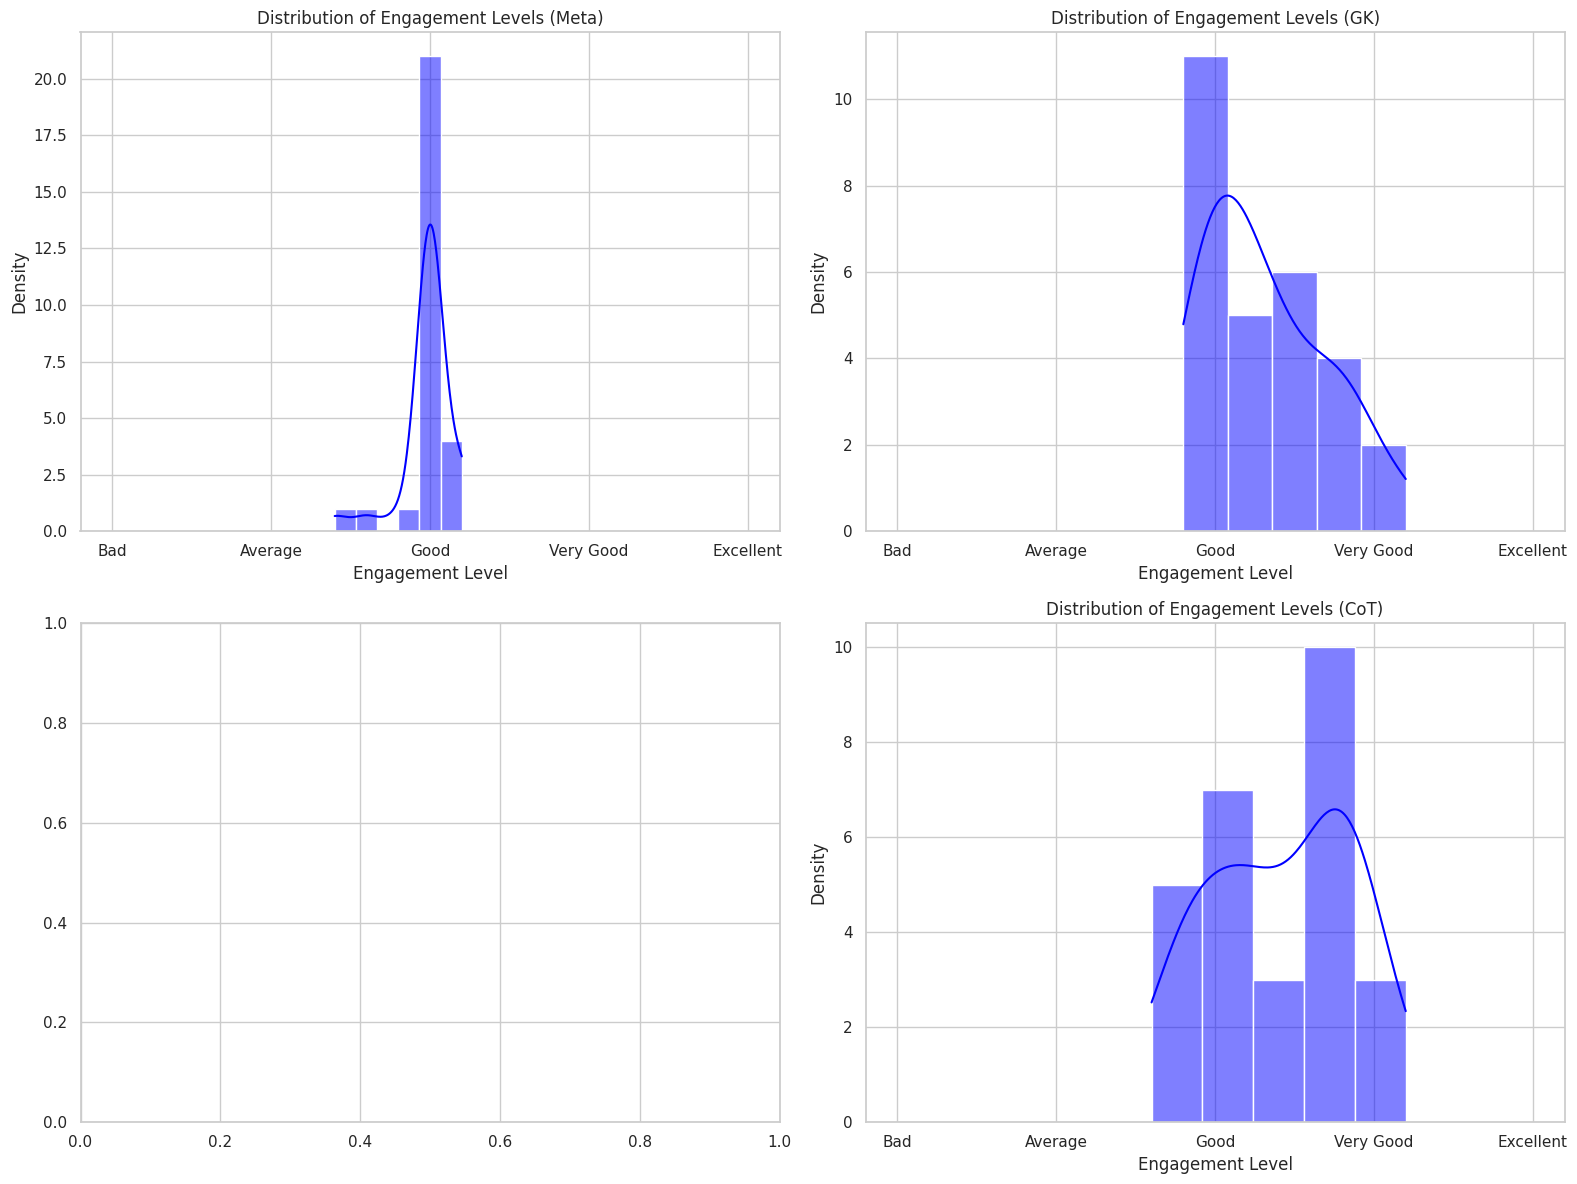

In [151]:
padding = 0.2

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.histplot(google_blog_evaluation["Meta prompt"].tolist(), bins=6, kde=True, color="blue", ax=axes[0, 0])
axes[0, 0].set_xticks(ticks=range(1, 6), labels=["Bad", "Average", "Good", "Very Good", "Excellent"])
axes[0, 0].set_xlim(1 - padding, 5 + padding)
axes[0, 0].set_xlabel("Engagement Level")
axes[0, 0].set_ylabel("Density")
axes[0, 0].set_title("Distribution of Engagement Levels (Meta)")

sns.histplot(google_blog_evaluation["Generated Knowledge prompt"].tolist(), bins=5, kde=True, color="blue", ax=axes[0, 1])
axes[0, 1].set_xticks(ticks=range(1, 6), labels=["Bad", "Average", "Good", "Very Good", "Excellent"])
axes[0, 1].set_xlim(1 - padding, 5 + padding)
axes[0, 1].set_xlabel("Engagement Level")
axes[0, 1].set_ylabel("Density")
axes[0, 1].set_title("Distribution of Engagement Levels (GK)")

sns.histplot(google_blog_evaluation["Five-shot prompt"].tolist(), bins=5, kde=True, color="blue", ax=axes[1, 0])
axes[1, 0].set_xticks(ticks=range(1, 6), labels=["Bad", "Average", "Good", "Very Good", "Excellent"])
axes[1, 0].set_xlim(1 - padding, 5 + padding)
axes[1, 0].set_xlabel("Engagement Level")
axes[1, 0].set_ylabel("Density")
axes[1, 0].set_title("Distribution of Engagement Levels (Five-shot)")

sns.histplot(google_blog_evaluation["Zero-shot CoT prompt"].tolist(), bins=5, kde=True, color="blue", ax=axes[1, 1])
axes[1, 1].set_xticks(ticks=range(1, 6), labels=["Bad", "Average", "Good", "Very Good", "Excellent"])
axes[1, 1].set_xlim(1 - padding, 5 + padding)
axes[1, 1].set_xlabel("Engagement Level")
axes[1, 1].set_ylabel("Density")
axes[1, 1].set_title("Distribution of Engagement Levels (CoT)")

plt.tight_layout()
plt.show()

# Test set